# (A) Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import PIL
from IPython.display import clear_output

# (B) Dataset

## Downloading the dataset
- [oxford_iiit_pet](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet)

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteLXCYT4/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteLXCYT4/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    sp

In [ ]:
train_ds, test_ds = dataset['train'], dataset['test']

# (C) Preprocessing

## Declerating Configurations

In [ ]:
# data
AUTOTUNE = tf.data.AUTOTUNE

# traning params
BATCH_SIZE = 64
BUFFER_SIZE = 1000
EPOCHS = 20

TRAIN_LENGTH = info.splits['train'].num_examples
TEST_LENGTH = info.splits['test'].num_examples

VAL_SUBSPLITS = 5
VALIDATION_STEPS = BATCH_SIZE // VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE


# model input size
width, height = 224, 224

## Util Functions

In [ ]:
def normalize(input_image, input_mask):
  
  # Convenient Dtype
  input_image = tf.cast(input_image, tf.float32)
  
  # scaling the image into 0-1 value range
  input_image =  input_image/ 255.0
  
  # Adjusting the mask values
  input_mask -= 1

  return input_image, input_mask


@tf.function
def load_train_ds(dataset):
	
	# unpackaging the data
	image = dataset['image']
	mask = dataset['segmentation_mask']

	# resizing the data
	image = tf.image.resize(image, (width, height) )
	mask = tf.image.resize(mask, (width, height) )

	# Data Augmentation
	if tf.random.uniform(()) > 0.5:
		image = tf.image.flip_left_right(image)
		mask = tf.image.flip_left_right(mask)

	# normalizing the data
	image, mask = normalize(image, mask)
	
	return image, mask

@tf.function
def load_test_ds(dataset):
	# unpackaging the data
	image = dataset['image']
	mask = dataset['segmentation_mask']

	# resizing the data
	image = tf.image.resize(image, (width, height))
	mask = tf.image.resize(mask, (width, height))

	# normalizing
	image, mask = normalize(image, mask)
	return image, mask


## Loading and preprocessing the dataset

In [ ]:
# loading the dataset
train = dataset['train'].map( load_train_ds, num_parallel_calls=AUTOTUNE)
test = dataset['test'].map(load_test_ds)

## Batching the dataset

In [ ]:
train_ds = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
test_ds = test.batch(BATCH_SIZE)

## Performance optimiation

In [ ]:
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## Visualization

In [ ]:
def display_images(images):

  titles = ['Input Image', 'True Mask', 'Predicted Mask']
  data_size = len(display_list)

  for i in range(data_size):

    # preparing the data
    image = keras.preprocessing.image.array_to_img(images[i])

    # Creating sub figure
    plt.subplot(1, data_size, i+1)
    
    # configurating
    plt.imshow(image)
    plt.title(titles[i])
    plt.axis('off')

  plt.show()

In [ ]:
# Getting the samples
sample_image, sample_mask = [], []
for img, mask in train.take(10):
  sample_image.append(img)
  sample_mask.append(mask) 

display_list= sample_image[0], sample_mask[0]

In [ ]:
np.array(sample_image).shape

(10, 224, 224, 3)

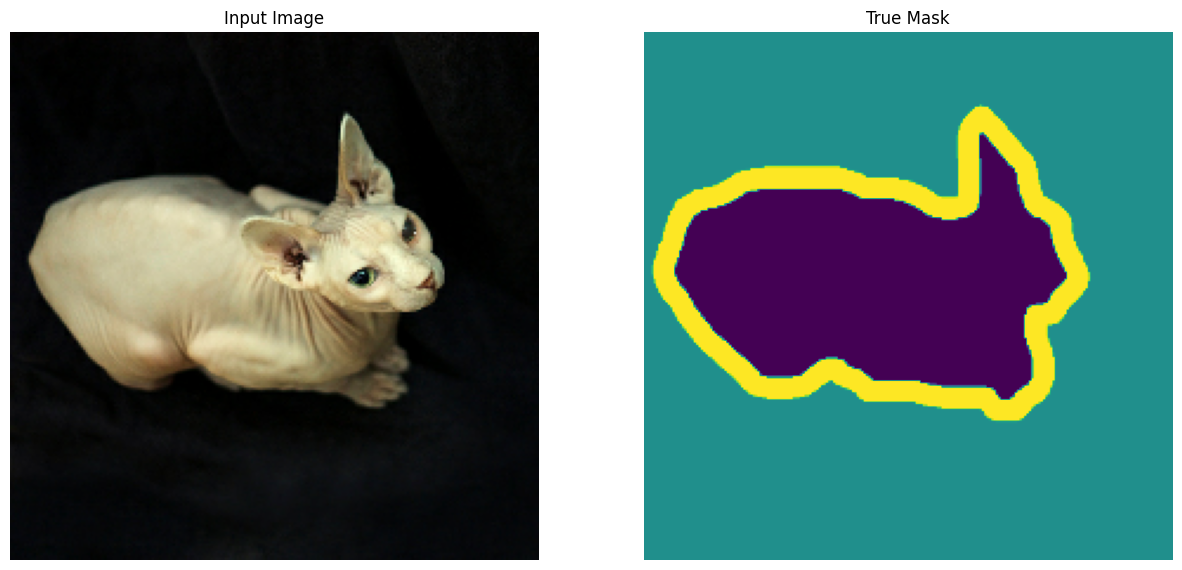

In [ ]:
plt.figure(figsize=(15, 15))
display_images(display_list)

# (D) Modelling

## Model Architecture

In [ ]:
bm_p = {
		"include_top":False,
		"input_shape":(width, height, 3)
}
base_model = keras.applications.vgg16.VGG16(**bm_p)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
layer_names = [
	'block1_pool',
	'block2_pool',
	'block3_pool',
	'block4_pool',
	'block5_pool',
]
base_model_outputs = [base_model.get_layer(name).output 
                      for name in layer_names]
base_model.trainable = False

In [ ]:
VGG_16 = tf.keras.models.Model(base_model.input, base_model_outputs)

In [ ]:
def fcn8_decoder(convs, n_classes):
	# Unpackaging the features
	f1, f2, f3, f4, p5 = convs

	# declerating the unit size
	n = 4096

	# Block-1
	c6_p = {
			"filters":n,
			"kernel_size":(7, 7),
			"activation":'relu',
			"padding":'same',
			"name":"conv6"
	}
	c7_p = {
			"filters":n,
			"kernel_size":(1, 1),
			"activation":'relu',
			"padding":'same',
			"name":"conv7"
	}
	c6 = tf.keras.layers.Conv2D(**c6_p)(p5)
	c7 = tf.keras.layers.Conv2D(**c7_p)(c6)
	f5 = c7

	# Block-2
	o1_p = {
			"filters":n_classes,
			"kernel_size":(4, 4),
			"strides":(2, 2),
			"use_bias":False
	}
	o2_p = {
			"filters":n_classes,
			"kernel_size":(1, 1),
			"activation":'relu',
			"padding":'same'
	}


	# upsample the output of the encoder
	# then crop extra pixels that were introduced
	o = tf.keras.layers.Conv2DTranspose(**o1_p)(f5)
	o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)
 
	# load the pool 4 prediction and do a 1x1
	# convolution to reshape it to the same shape of `o` above
	o2 = f4
	o2 = tf.keras.layers.Conv2D(**o2_p)(o2)

	# add the results of the upsampling and pool 4 prediction
	o = tf.keras.layers.Add()([o, o2])

	# Block-3
	o3_p = {
			"filters":n_classes,
			"kernel_size":(4, 4),
			"strides":(2, 2),
			"use_bias":False
	}
	o4_p = {
			"filters":n_classes, 
			"kernel_size":(1, 1),
			"activation":'relu',
			"padding":'same'
	}

	# upsample the resulting tensor of the operation you just did
	o = tf.keras.layers.Conv2DTranspose(**o3_p)(o)
	o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

	# load the pool 3 prediction and do a 1x1
	# convolution to reshape it to the same shape of `o` above
	o2 = f3
	o2 = tf.keras.layers.Conv2D(**o4_p)(o2)

	# add the results of the upsampling and pool 3 prediction
	o = tf.keras.layers.Add()([o, o2])

	# Block-3
	o5_p = {
			"filters":n_classes,
			"kernel_size":(8, 8), 
			"strides":(8, 8),
			"use_bias":False
	}
	# upsample up to the size of the original image
	o = tf.keras.layers.Conv2DTranspose(**o5_p)(o)

	# append a softmax to get the class probabilities
	o = tf.keras.layers.Activation('softmax')(o)
	return o


In [ ]:
def segmentation_model():

	# input layer
	inputs = keras.layers.Input(shape=(width, height, 3))
	
	# hidden layers (feature extraction)
	convs = VGG_16(inputs)
	
	# output layer as decoder
	outputs = fcn8_decoder(convs, 3)
	
	# connecting the model
	model = tf.keras.Model(inputs=inputs, outputs=outputs)

	return model

In [ ]:
# building the model
model = segmentation_model()

# Configurating the model
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer="adam",loss=loss,metrics=['accuracy'])

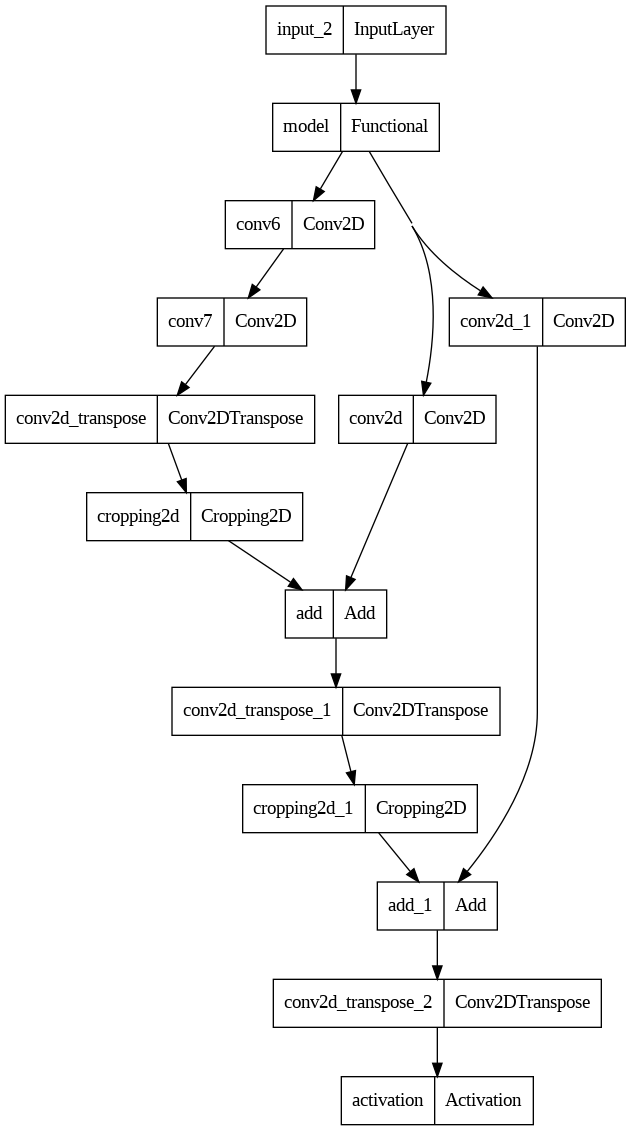

In [ ]:
tf.keras.utils.plot_model(model)

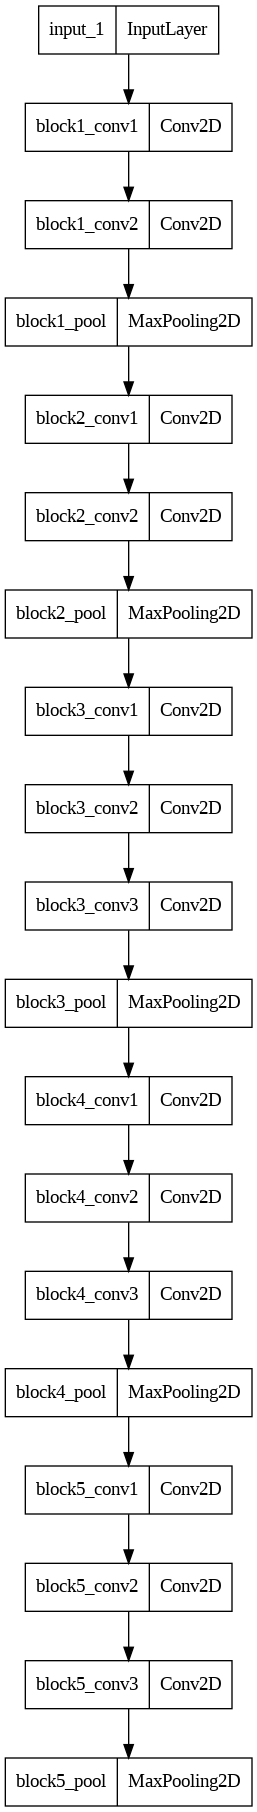

In [ ]:
tf.keras.utils.plot_model(VGG_16)

## Training

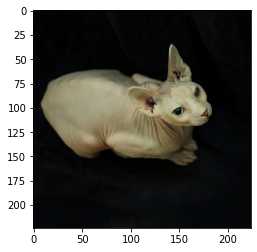

In [ ]:
plt.imshow(sample_image[0])

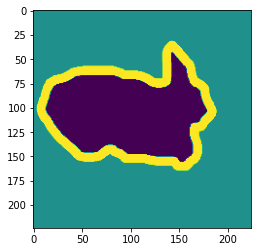

In [ ]:
plt.imshow(sample_mask[0])

In [ ]:
def create_mask(pred_mask):
  # gray scaling
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]

  return pred_mask[0]


def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):

      # Segmentating the image
      pred_mask = model.predict(image)
      
      # Displaying the result
      display_images([image[0], mask[0], create_mask(pred_mask)])
  else:
      # preparing the params
      img = sample_image[0]
      mask = sample_mask[0]
      pred = create_mask(model.predict(img[tf.newaxis, ...]))

      # displaying the datta
      display_images([img, mask, pred])

1/1 [==============================] - 1s 885ms/step


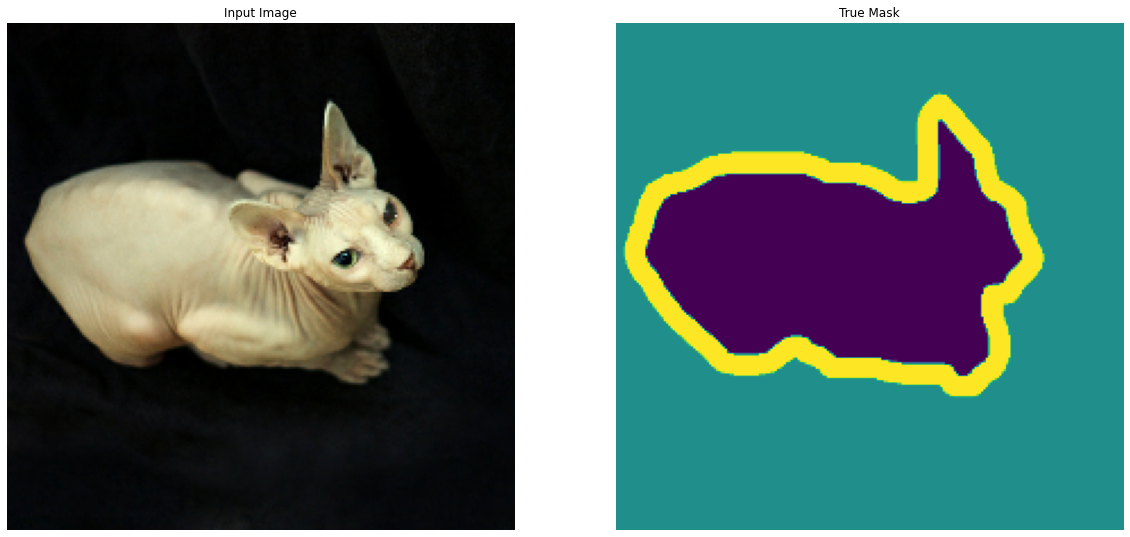

In [ ]:
plt.figure(figsize=(20,10))
show_predictions();

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, LambdaCallback
import numpy as np

def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 15
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate

def print_current_lr(epoch, logs):
    print("Learning rate in epoch {} is {}".format(epoch, float(tf.keras.backend.get_value(model.optimizer.lr))))

# Temporary save paths
checkpoint_path = "TemporaryModel_ModelCheckpoint.h5"
tb_log_dir = "./logs"

In [ ]:
callbacks = [
    #DisplayCallback(model),
    #LearningRateScheduler(step_decay),
    TensorBoard(log_dir=tb_log_dir),
    ModelCheckpoint(filepath= checkpoint_path, save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    CSVLogger(filename='training.log'),
    #LambdaCallback(on_epoch_end=print_current_lr)
]

In [ ]:
train_params = {
    "epochs":EPOCHS,
    "steps_per_epoch":STEPS_PER_EPOCH,
    "validation_steps":VALIDATION_STEPS,
    "validation_data":test_ds,
    "callbacks":callbacks
}

In [ ]:
history = model.fit(train_ds, **train_params)

Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 1.0200 - accuracy: 0.4600
Epoch 1: val_loss improved from inf to 0.70178, saving model to TemporaryModel_ModelCheckpoint.h5
57/57 [==============================] - 56s 954ms/step - loss: 1.0200 - accuracy: 0.4600 - val_loss: 0.7018 - val_accuracy: 0.6889
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 0.5279 - accuracy: 0.7825
Epoch 2: val_loss improved from 0.70178 to 0.47068, saving model to TemporaryModel_ModelCheckpoint.h5
57/57 [==============================] - 53s 942ms/step - loss: 0.5279 - accuracy: 0.7825 - val_loss: 0.4707 - val_accuracy: 0.8059
Epoch 3/20
57/57 [==============================] - ETA: 0s - loss: 0.4236 - accuracy: 0.8225
Epoch 3: val_loss improved from 0.47068 to 0.45066, saving model to TemporaryModel_ModelCheckpoint.h5
57/57 [==============================] - 49s 858ms/step - loss: 0.4236 - accuracy: 0.8225 - val_loss: 0.4507 - val_accuracy: 0.8121
Epoch 4/20
57/57 [==

In [ ]:
"""
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_ds, epochs=EPOCHS,
						steps_per_epoch=STEPS_PER_EPOCH,
						validation_steps=VALIDATION_STEPS,
						validation_data=test_ds)
"""

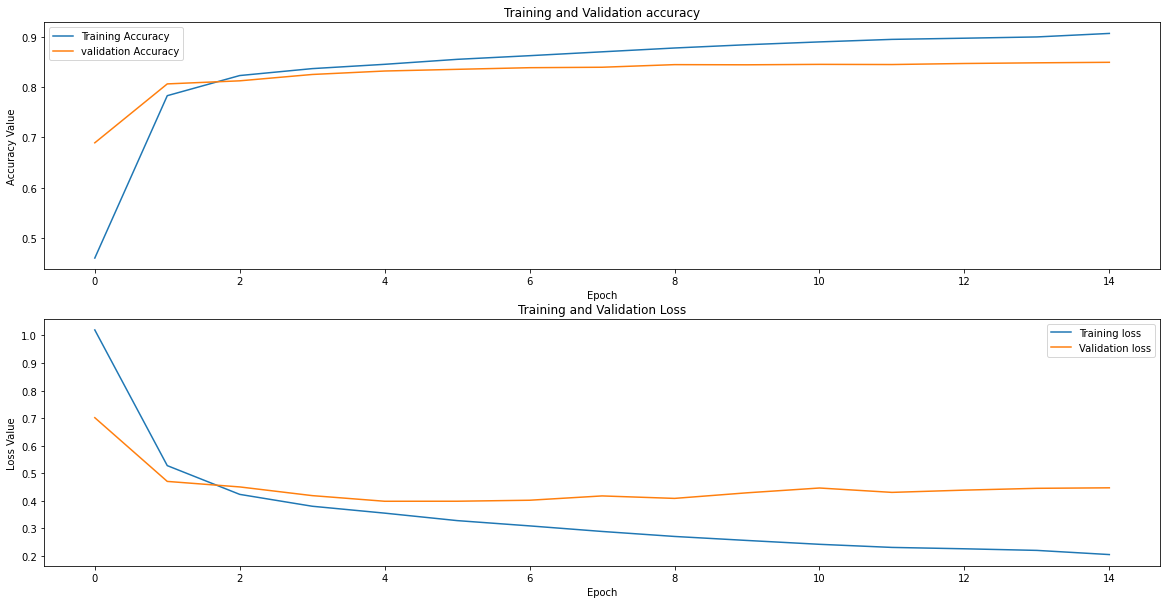

In [ ]:
# extracting the data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# creating the figure
plt.figure(figsize=(20,10))

# plotting
plt.subplot(2,1,1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='validation Accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
plt.legend()

plt.subplot(2,1,2)
plt.plot(range(len(loss)), loss, label='Training loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()

## Saving the results

### Model

In [ ]:
# Load the best weights
model.load_weights(checkpoint_path)

# best_model = tf.keras.models.load_model('saved_model/my_model') # best_model_save_path

In [ ]:
from datetime import datetime
best_model_save_path = "fine_tuned_VGG16.h5" 
model.save(best_model_save_path)

In [ ]:
# Zipping the model to download
dst, src = f"{best_model_save_path}.zip", best_model_save_path
os.system(f"zip -r {dst} {src}")

0

In [ ]:
# Copying the model into my google drive
os.system(f"cp -r {best_model_save_path} /content/drive/MyDrive/Home/Projects/ImageSegmentation ")

In [ ]:
# Downloading the zipped model into the local
from google.colab import files
files.download(dst)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 42ms/step


In [ ]:
w_dir = "UnetSegmentation_weights"
if not os.path.exists(w_dir):os.mkdir(w_dir)
model.save_weights(f'{w_dir}/UnetSegmentation_weights')

In [ ]:
os.system(f"cp -r {w_dir}/UnetSegmentation_weights /content/drive/MyDrive/Home/Projects/ImageSegmentation ")

256

### Evaluation

```python
def compute_metrics(y_true, y_pred):
	class_wise_iou = []
	class_wise_dice_score = []

	smoothening_factor = 0.00001

	for i in range(3):

		# extracting the params
		intersection = np.sum((y_pred == i) * (y_true == i))
		y_true_area = np.sum((y_true == i))
		y_pred_area = np.sum((y_pred == i))
		combined_area = y_true_area + y_pred_area

		# calculating iou
		retlated = intersection + smoothening_factor
		total = combined_area - intersection + smoothening_factor
		
		iou = retlated / total
		class_wise_iou.append(iou)

		# calculating the score
		com = (combined_area + smoothening_factor)
		
		dice_score = 2 * (retlated / com)
		class_wise_dice_score.append(dice_score)

	return class_wise_iou, class_wise_dice_score
```

```python
def get_test_data():
	# adjusting the dataset shape to get sample
	ds = test_ds.unbatch()
	ds = ds.batch(info.splits['test'].num_examples)

	# getting the images
	images = []
	y_true_segments = []
	for image, annotation in ds.take(1):
		y_true_segments = annotation.numpy()
		images = image.numpy()

	# calculating the corresponding data
	test_size =info.splits['test'].num_examples
	test_index =  test_size - (test_size % BATCH_SIZE)

	# getting the annotations
	y_true_segments = y_true_segments[:test_index]
	images = images[:test_index]

	return images, y_true_segments

def display_prediction(display_list, message):
	#plt.figure(figsize=(15, 15))
	titles = ['Input Image', 'True Mask', 'Predicted Mask']

	for i in range(len(display_list)):
		
		# plotting the figure into an subplot
		plt.subplot(1, len(display_list), i+1)

		# plotting 
		plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
		
		# configurating
		if i == 1: plt.xlabel(message, fontsize=12)
		plt.title(titles[i])
		plt.xticks([])
		plt.yticks([])
```

```python
# getting the annotations
y_true_images, y_true_segments = get_test_data()

# adjusting the image to preidction
integer_slider = 2574
img = np.reshape(y_true_images[integer_slider], (1, width, height, 3))

# predictions
y_pred_mask = model.predict(img)

# revising the mask
y_pred_mask = create_mask(y_pred_mask)
y_pred_mask.shape
```

```python
# Calculating the scores
iou, dice_score = compute_metrics( y_true_segments[integer_slider], y_pred_mask.numpy())
```

```python
# preparing the plotting params
display_list = [y_true_images[integer_slider], y_true_segments[integer_slider], y_pred_mask]
message = [f"IOU: {i:>5.4} Dice Score: {dc:>5.4}" 
           for (i, dc) in zip(iou, dice_score) ]
messages = "\n\n".join(message)


# showing predictions with metrics
display_prediction(display_list, messages)
```

# (E) Deployment Web app

In [ ]:
import os
if os.system("pip freeze | greb gradio")!=0:os.system("pip install gradio")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
src = "/content/drive/MyDrive/Home/Projects/DeepLearningProjects/Image/17_[ImageSegmentation]pet_segmentation/CustomImageSegmentation/fine_tned_VGG16.h5" # /content/drive/MyDrive/Home/Projects/ImageSegmentation/UnetSegmentation.h5
dst = "fine_tned_VGG16.h5"
os.system(f"cp -r {src} {dst}")

0

In [ ]:
!unzip sample_images.zip

Archive:  sample_images.zip
   creating: sample_images/
   creating: sample_images/masks/
  inflating: sample_images/masks/mask_1.png  
  inflating: sample_images/masks/mask_0.png  
  inflating: sample_images/masks/mask_3.png  
  inflating: sample_images/masks/mask_2.png  
   creating: sample_images/images/
 extracting: sample_images/images/image_0.png  
  inflating: sample_images/images/image_3.png  
  inflating: sample_images/images/image_1.png  
  inflating: sample_images/images/image_2.png  


In [ ]:
#!unzip BasicModel.zip

In [ ]:
import gradio as gr
import tensorflow as tf
from glob import glob
import cv2
import os
import numpy as np

model_path = "fine_tuned_VGG16.h5"
model = tf.keras.models.load_model(model_path)

In [ ]:
def process_image(image):
    # Convert into tensor
    image = tf.convert_to_tensor(image)

    # Cast the image to tf.float32
    image = tf.cast(image, tf.float32)
    
    # Resize the image to img_resize
    image = tf.image.resize(image, (224,224))
    
    # Normalize the image
    image /= 255.0
    
    # Return the processed image and label
    return image

def finalize_segmentation(prediction):#;, shape):
  
  seg_img = cv2.cvtColor(prediction, cv2.COLOR_BGR2GRAY)
  th = seg_img.mean()
  _, thresholded = cv2.threshold(seg_img, th, 255, cv2.THRESH_BINARY)
  #thresholded = cv2.resize(thresholded, shape[:2])

  return np.uint8(thresholded)

def paint_transparent(mask, image):
    
    # Declerating the params
    overlay_color = (0, 255, 0)  # green
    alpha = 0.5
    
    # Adjsuting the mask shape
    shape = image.shape
    mask = cv2.resize(mask, (shape[1], shape[0]))

    # Drawing the object
    overlay = np.zeros_like(image)
    overlay[:, :, :] = overlay_color
    
    # Implementing the mask according to notation (0->object, 255->not object :> bitwise_not)
    overlay = cv2.bitwise_not(overlay, overlay, mask=mask)
    
    # transparent concatenation
    output = cv2.addWeighted(image, 1 - alpha, overlay, alpha, 0)

    return output

def predict(image):

  # Pre-procesing the data
  images = process_image(image)
  #shape = images.shape

  # Batching
  batched_images = tf.expand_dims(images, axis=0)
  
  prediction = model.predict(batched_images)[0]

  mask = finalize_segmentation(prediction)#, shape)

  segmented_image = paint_transparent(mask, image)

  return segmented_image

1/1 [==============================] - 1s 747ms/step


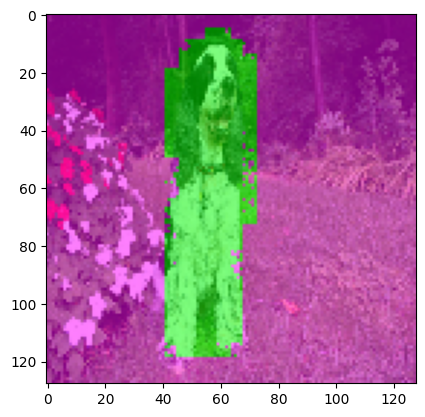

In [ ]:
import matplotlib.pyplot as plt
example_img = cv2.imread("/content/sample_images/images/image_1.png")[...,::-1]
seg_img = predict(example_img)
plt.imshow(seg_img)

In [ ]:
demo = gr.Interface(fn=predict, 
             inputs=gr.Image(shape=(224, 224), type="numpy"),
             outputs=gr.Image(),
             examples="sample_images/images")
             
demo.launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>